In [1]:
import warnings 
warnings.filterwarnings('ignore')
import os
# os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
import sys
sys.path.append('.')
sys.path.append('..')
import yaml 
import argparse
import traceback
import time
import torch

from model.models import STSSL
from model.trainer import Trainer
from lib.dataloader import get_dataloader
from lib.utils import (
    init_seed,
    get_model_params,
    load_graph, 
)

In [16]:
parser = argparse.ArgumentParser()
parser.add_argument('--config_filename', default=r'D:\omer\onlineJEPATrain\configs\NYCTaxi.yaml', 
                type=str, help='the configuration to use')
args, unknown = parser.parse_known_args()
print(f'Starting experiment with configurations in {args.config_filename}...')
time.sleep(3)
configs = yaml.load(
    open(args.config_filename), 
    Loader=yaml.FullLoader
)
configs['graph_init'] = "batched_cheb"

configs['self_attention_flag'] = True
configs['cross_attention_flag'] = False
configs['feedforward_flag'] = False
configs['layer_norm_flag'] = False
configs['additional_sa_flag'] = False
configs['learnable_flag'] = False
configs['pos_emb_flag'] = False
configs['rank'] = False
configs['add_8'] = True
configs['add_eye'] = False
configs['add_x_encoder'] = False
configs['freeze_encoder'] = True
configs['cheb_order'] = 3
configs['experimentName'] = "test"
configs['S_Loss'] = False
configs['T_Loss'] = False
configs['seed'] = 2
configs['comment'] = "noComment"
configs['ipe'] = 1000
    
args = argparse.Namespace(**configs)


Starting experiment with configurations in D:\omer\onlineJEPATrain\configs\NYCTaxi.yaml...


In [17]:
print(args.seed)

2


In [18]:
init_seed(args.seed)
if not torch.cuda.is_available():
    args.device = 'cuda'

## load dataset
dataloader = get_dataloader(
    data_dir=args.data_dir, 
    dataset=args.dataset, 
    batch_size=args.batch_size, 
    test_batch_size=args.test_batch_size,
    scalar_type='Standard'
)
graph = load_graph(args.graph_file, device=args.device)
args.num_nodes = len(graph)

## init model and set optimizer
model = STSSL(args).to(args.device)

args.best_path = r'D:\omer\onlineJEPATrain\experiments\NYCTaxi\pred__seed=2\20240701-223622\fixed encoder, learning weights, only view1, with softmax, with 8_neighbours\best_model.pth'
state_dict = torch.load(
                args.best_path,
                map_location=torch.device(args.device)
            )
msg = model.load_state_dict(state_dict['model'])
print("Load saved model msg: ", msg)

model_parameters = get_model_params([model])
optimizer = torch.optim.Adam(
    params=model_parameters, 
    lr=args.lr_init, 
    eps=1.0e-8, 
    weight_decay=0, 
    amsgrad=False
)



!!Scaling is NOT off!!


data['x_train'].shape:  (1912, 35, 200, 2) (1912, 1, 200, 2) 

!!train shuffle is True!!


encoder msg: <All keys matched successfully>
Freezing encoder
Load saved model msg:  <All keys matched successfully>


In [19]:
## start training
trainer = Trainer(
    model=model, 
    optimizer=optimizer, 
    dataloader=dataloader,
    graph=graph, 
    args=args
)

2024-07-03 11:59:43: 
Model has 0.923788 M trainable parameters
2024-07-03 11:59:43: Experiment log path in: D:\omer\onlineJEPATrain\experiments\NYCTaxi\test\20240703-115943\noComment
2024-07-03 11:59:43: Experiment configs are: Namespace(seed=2, device='cuda', mode='test', best_path='D:\\omer\\onlineJEPATrain\\experiments\\NYCTaxi\\pred__seed=2\\20240701-223622\\fixed encoder, learning weights, only view1, with softmax, with 8_neighbours\\best_model.pth', debug=False, data_dir='data', dataset='NYCTaxi', input_length=35, batch_size=32, test_batch_size=32, graph_file='data/NYCTaxi/adj_mx.npz', num_nodes=200, row=20, col=10, d_input=2, d_output=2, d_model=64, dropout=0.1, percent=0.1, shm_temp=0.5, nmb_prototype=4, yita=0.5, start_epoch=0, num_epochs=1000, epochs=1000, lr_init=0.001, early_stop=True, early_stop_patience=35, grad_norm=True, max_grad_norm=5, use_dwa=True, temp=2, graph_init='batched_cheb', self_attention_flag=True, cross_attention_flag=False, feedforward_flag=False, layer_

Creat Log File in:  D:\omer\onlineJEPATrain\experiments\NYCTaxi\test\20240703-115943\noComment\run.log


In [20]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from lib.metrics import test_metrics


def test(model, dataloader, scaler, graph, logger, args):
    model.eval()
    y_pred = []
    y_true = []
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(dataloader):
            repr1, repr2, _, _ = model(data, graph)                
            pred_output = model.predict(repr1, repr2)

            y_true.append(target)
            y_pred.append(pred_output)

    # y_true = torch.cat(y_true, dim=0).cpu().numpy()
    # y_pred = torch.cat(y_pred, dim=0).cpu().numpy()
    y_true = scaler.inverse_transform(torch.cat(y_true, dim=0)).cpu().numpy()
    y_pred = scaler.inverse_transform(torch.cat(y_pred, dim=0)).cpu().numpy()
    mask = np.where(y_true > (5), True, False)
    # true = true[mask]
    # pred = pred[mask]
    test_results = []
    # inflow
    mae, mape = test_metrics(y_pred[..., 0], y_true[..., 0])
    logger.info("test, MAE: {:.2f}, test MAPE: {:.4f}%".format(mae, mape*100))
    test_results.append([mae, mape])
    
    print("y_true.shape: ", y_true.shape, "y_pred.shape: ", y_pred.shape)

    # Plotting
    plt.figure(figsize=(10, 5))
    
    ## to plot all regions 
    # plt.plot(y_true[..., 0].flatten()[3000:4000], label='True Values')
    # plt.plot(y_pred[..., 0].flatten()[3000:4000], label='Predictions')
    ## to plot summed up regions
    # plt.plot(np.sum(y_true[:, :, :, :], axis=2).flatten()
    #         , label='True Values')
    # plt.plot(np.sum(y_pred[:, :, :, :], axis=2).flatten(), label='Predictions')
    mask = y_true > 5

    # Apply the mask to y_true and y_pred to filter values
    masked_y_true = np.where(mask, y_true, np.nan)  # Replace unmasked values with NaN
    masked_y_pred = np.where(mask, y_pred, np.nan)  # Same for y_pred

    # Sum and flatten the masked values for plotting
    # Using np.nansum to ignore NaN values in summation
    summed_masked_y_true = np.nansum(masked_y_true, axis=2).flatten()
    summed_masked_y_pred = np.nansum(masked_y_pred, axis=2).flatten()
    plt.plot(summed_masked_y_true, label='True Values (Masked)')
    plt.plot(summed_masked_y_pred, label='Predictions (Masked)')
    plt.title("Comparison of True and Predicted Values")
    plt.xlabel("Sample")
    plt.ylabel("Value")
    plt.legend()
    plt.show()

    # outflow 
    mae, mape = test_metrics(y_pred[..., 1], y_true[..., 1])
    logger.info("OUTFLOW, MAE: {:.2f}, MAPE: {:.4f}%".format(mae, mape*100))
    # test_results.append([mae, mape]) 

    return np.stack(test_results, axis=0)


In [21]:
def test(model, dataloader, scaler, graph, logger, args):
    model.eval()
    y_pred = []
    y_true = []
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(dataloader):
            repr1, repr2, _, _ = model(data, graph)                
            pred_output = model.predict(repr1, repr2)

            y_true.append(target)
            y_pred.append(pred_output)
    y_true = scaler.inverse_transform(torch.cat(y_true, dim=0))
    y_pred = scaler.inverse_transform(torch.cat(y_pred, dim=0))

    test_results = []
    # inflow
    # print("y_pred.shape: ", y_pred.shape, "y_true.shape: ", y_true.shape)
    mae, mape = test_metrics(y_pred[..., 0], y_true[..., 0])
    logger.info("INFLOW, MAE: {:.2f}, MAPE: {:.4f}%".format(mae, mape*100))
    test_results.append([mae, mape])
    # outflow 
    mae, mape = test_metrics(y_pred[..., 1], y_true[..., 1])
    logger.info("OUTFLOW, MAE: {:.2f}, MAPE: {:.4f}%".format(mae, mape*100))
    test_results.append([mae, mape]) 

    return np.stack(test_results, axis=0)

In [22]:
test(model, dataloader['test'], dataloader['scaler'],
            graph, trainer.logger, trainer.args)

2024-07-03 11:59:47: INFLOW, MAE: 28.59, MAPE: 144.6856%
2024-07-03 11:59:47: OUTFLOW, MAE: 11.77, MAPE: 27.5873%


array([[28.58858109,  1.44685555],
       [11.77119541,  0.27587274]])

In [15]:
state_dict = torch.load(
    args.best_path,
    map_location=torch.device(args.device)
)
model.load_state_dict(state_dict['model'])
print("Load saved model")
results = trainer.test(model, dataloader['test'], dataloader['scaler'],
            graph, trainer.logger, trainer.args)

Load saved model


2024-07-03 11:55:53: INFLOW, MAE: 28.59, MAPE: 144.6856%
2024-07-03 11:55:53: OUTFLOW, MAE: 11.77, MAPE: 27.5873%


In [8]:

def test_rolling(model, dataloader, scaler, graph, logger, args):
    model.eval()
    y_pred = []
    y_true = []
    prediction_buffer = None  # Buffer to hold predictions for future time steps

    # torch.Size([batch_size=1, time_steps=19, no.ofnodes=285, features=1]) data shape
    # torch.Size([1, 1, 285, 1]) pred_output shape
    # print("len(dataloader): ", len(dataloader))
    with torch.no_grad():
        for idx, (data, target) in enumerate(dataloader):
            # print(f"idx: {idx}, data.shape: {data.shape}, target.shape: {target.shape}")
            # Update data with predictions from buffer
            if prediction_buffer is not None:
                for t in range(len(prediction_buffer)):
                    if t <= data.shape[1]:  # Ensure the time step exists in the data
                        # print("data.shape: ", data.shape, "data[:, t, :, :].shape: ", data[:, t, :, :].shape, "prediction_buffer[t].shape: ", prediction_buffer[t].shape)
                        # print(f"for data at index {idx} replacing data[:, {t}, :, :] with prediction_buffer[{t}]")
                        data[:, t, :, :] = prediction_buffer[t].squeeze(1)

            repr1, repr2 = model(data, graph)
            pred_output = model.predict(repr1, repr2)

            y_true.append(target)
            y_pred.append(pred_output)

            # Update the prediction buffer
            if prediction_buffer is None:
                prediction_buffer = [pred_output]
            else:
                prediction_buffer.insert(0, pred_output)  ## insert at 0th index
                prediction_buffer = prediction_buffer[:data.shape[1]]  # Keep buffer size same as the number of time steps

    y_true = torch.cat(y_true, dim=0).cpu().numpy()
    y_pred = torch.cat(y_pred, dim=0).cpu().numpy()
    # y_true = scaler.inverse_transform(torch.cat(y_true, dim=0)).cpu().numpy()
    # y_pred = scaler.inverse_transform(torch.cat(y_pred, dim=0)).cpu().numpy()

    test_results = []

    print("y_true.shape: ", y_true.shape, "y_pred.shape: ", y_pred.shape)

    # Plotting
    plt.figure(figsize=(10, 5))
    
    ## to plot all regions 
    # plt.plot(y_true[..., 0].flatten()[3000:3100], label='True Values')
    # plt.plot(y_pred[..., 0].flatten()[3000:3100], label='Predictions')
    ## to plot summed up regions
    plt.plot(np.sum(y_true[:, :, :, :], axis=2).flatten(), label='True Values')
    plt.plot(np.sum(y_pred[:, :, :, :], axis=2).flatten(), label='Predictions')
    
    plt.title("Comparison of True and Predicted Values")
    plt.xlabel("Sample")
    plt.ylabel("Value")
    plt.legend()
    plt.show()
    
    # inflow
    mae, mape = test_metrics(y_pred[..., 0], y_true[..., 0])
    logger.info("rolling, MAE: {:.2f}, rolling MAPE: {:.4f}%".format(mae, mape*100))
    test_results.append([mae, mape])

    return np.stack(test_results, axis=0)

y_true.shape:  (864, 1, 128, 2) y_pred.shape:  (864, 1, 128, 2)


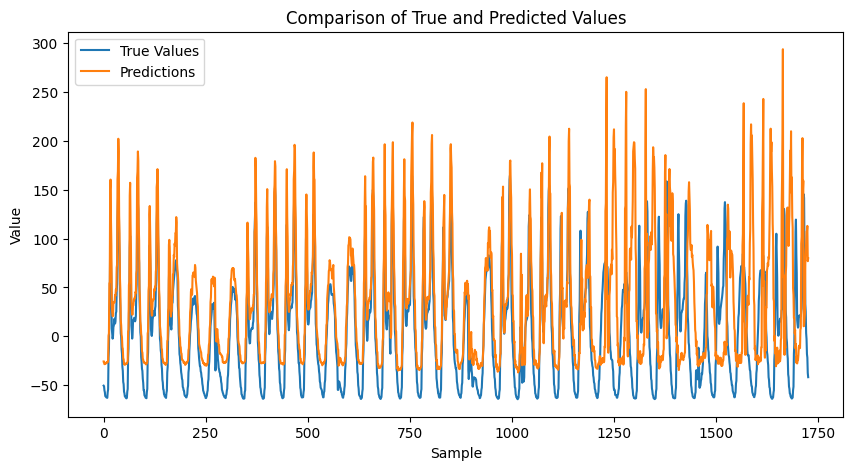

2024-02-07 02:01:54: rolling, MAE: 0.50, rolling MAPE: 129.6789%


array([[0.49504986, 1.296789  ]], dtype=float32)

In [9]:
test_rolling(model, dataloader['test'], dataloader['scaler'],
            graph, trainer.logger, trainer.args)

In [10]:
# args.best_path = r"D:\omer\ST-SSL\experiments\Careem_linear\20240130-100155\best_model.pth"
# state_dict = torch.load(
#                 args.best_path,
#                 map_location=torch.device(args.device)
#             )
# model.load_state_dict(state_dict['model'])
# print("Load saved model")
# results = trainer.test(model, dataloader['test'], dataloader['scaler'],
#             graph, trainer.logger, trainer.args)
# results_rolling = trainer.test_rolling(model, dataloader['test'], dataloader['scaler'],
#             graph, trainer.logger, trainer.args)

In [11]:
# def read_data(file_path):
#     preds = []
#     true_labels = []
#     with open(file_path, 'r') as file:
#         for line in file:
#             pred, true_label = line.strip().split(',')
#             preds.append(float(pred))
#             true_labels.append(int(true_label))
#     return preds, true_labels

# preds, true_labels = read_data(r"D:\omer\c2d2\surgvisdom_pred.txt")

In [12]:
# import numpy as np
# from sklearn.metrics import f1_score, balanced_accuracy_score

# def val_metrics(preds, true_labels, indices):
    

#     mean_weighted_f1 = 0.0
#     mean_unweighted_f1 = 0.0
#     mean_global_f1 = 0.0
#     mean_balanced_acc = 0.0

#     for i in range(15):
#         start_idx = indices[i]
#         end_idx = indices[i + 1]

#         group_preds = preds[start_idx:end_idx]
#         group_true_labels = true_labels[start_idx:end_idx]

#         mean_weighted_f1 += f1_score(group_true_labels, group_preds, average='weighted') / 16.0
#         mean_unweighted_f1 += f1_score(group_true_labels, group_preds, average='macro') / 16.0
#         mean_global_f1 += f1_score(group_true_labels, group_preds, average='micro') / 16.0
#         mean_balanced_acc += balanced_accuracy_score(group_true_labels, group_preds) / 16.0

#     print('Weighted F1: {}'.format(mean_weighted_f1))
#     print('Unweighted F1: {}'.format(mean_unweighted_f1))
#     print('Global F1: {}'.format(mean_global_f1))
#     print('Balanced Accuracy: {}'.format(mean_balanced_acc))

#     return mean_weighted_f1, mean_unweighted_f1, mean_global_f1, mean_balanced_acc

# indices = [0, 209, 381, 997, 1132, 1288, 1428, 1742, 1796, 2041, 2202, 2959, 3124, 3308, 3789, 4385, 4496]

# results = val_metrics(preds, true_labels, indices)


In [13]:
# import numpy as np

# diff_indices = np.diff(indices)
# print(diff_indices)
